In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import sparse

sns.set(style="whitegrid")


In [2]:

df = pd.read_csv("Student Mental health.csv")

df.rename(columns={
    'Choose your gender': 'Gender',
    'What is your course?': 'Course',
    'Your current year of Study': 'Year of Study',
    'What is your CGPA?': 'CGPA',
    'Do you have Depression?': 'Depression',
    'Do you have Anxiety?': 'Anxiety',
    'Do you have Panic attack?': 'Panic attack',
    'Did you seek any specialist for a treatment?': 'Seek help'
}, inplace=True)

print("✅ Kolom berhasil direname:")
print(df.columns.tolist())


✅ Kolom berhasil direname:
['Timestamp', 'Gender', 'Age', 'Course', 'Year of Study', 'CGPA', 'Marital status', 'Depression', 'Anxiety', 'Panic attack', 'Seek help']


In [3]:

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

df['CGPA'] = df['CGPA'].astype(str).str.replace(',', '.')
df['CGPA'] = df['CGPA'].str.extract(r'(\d+\.?\d*)')[0]
df['CGPA'] = pd.to_numeric(df['CGPA'], errors='coerce')

before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"🧹 Data duplikat dihapus: {before - after}")

num_cols = ['Age', 'CGPA']
cat_cols = ['Gender', 'Course', 'Year of Study', 'Marital status', 'Anxiety', 'Panic attack', 'Seek help']

for col in num_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)
    print(f"➡️ Nilai kosong di kolom {col} diisi median: {median_val}")

for col in cat_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)
    print(f"➡️ Nilai kosong di kolom {col} diisi modus: {mode_val}")

print("\n✅ Cek nilai kosong setelah cleaning:")
print(df.isnull().sum())


🧹 Data duplikat dihapus: 0
➡️ Nilai kosong di kolom Age diisi median: 19.0
➡️ Nilai kosong di kolom CGPA diisi median: 3.0
➡️ Nilai kosong di kolom Gender diisi modus: Female
➡️ Nilai kosong di kolom Course diisi modus: BCS
➡️ Nilai kosong di kolom Year of Study diisi modus: year 1
➡️ Nilai kosong di kolom Marital status diisi modus: No
➡️ Nilai kosong di kolom Anxiety diisi modus: No
➡️ Nilai kosong di kolom Panic attack diisi modus: No
➡️ Nilai kosong di kolom Seek help diisi modus: No

✅ Cek nilai kosong setelah cleaning:
Timestamp         0
Gender            0
Age               0
Course            0
Year of Study     0
CGPA              0
Marital status    0
Depression        0
Anxiety           0
Panic attack      0
Seek help         0
dtype: int64


In [4]:

binary_map = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}
for col in ['Gender', 'Marital status', 'Anxiety', 'Panic attack', 'Seek help', 'Depression']:
    df[col] = df[col].map(binary_map)

print("✅ Kolom biner berhasil dikonversi.")
print(df[['Gender','Anxiety','Depression']].head())


✅ Kolom biner berhasil dikonversi.
   Gender  Anxiety  Depression
0       0        0           1
1       1        1           0
2       1        1           1
3       0        0           1
4       1        0           0


In [5]:

X = df.drop(columns=['Depression','Timestamp'])
y = df['Depression']

num_cols = ['Age','CGPA']
bin_cols = ['Gender','Marital status','Anxiety','Panic attack','Seek help']
cat_cols = ['Course','Year of Study']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"📊 Data Train: {X_train.shape}, Data Test: {X_test.shape}")


📊 Data Train: (80, 9), Data Test: (21, 9)


In [6]:

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
    ('bin', 'passthrough', bin_cols)
])

svm_model = Pipeline([
    ('prep', preprocess),
    ('model', SVC(kernel='rbf', C=1, gamma='scale', random_state=42))
])

svm_model.fit(X_train, y_train)
print("✅ Model SVM berhasil dilatih tanpa error atau warning.")


✅ Model SVM berhasil dilatih tanpa error atau warning.


Akurasi Model: 0.762
Classification Report:
               precision    recall  f1-score   support

Tidak Depresi       0.76      0.93      0.84        14
      Depresi       0.75      0.43      0.55         7

     accuracy                           0.76        21
    macro avg       0.76      0.68      0.69        21
 weighted avg       0.76      0.76      0.74        21



c:\Users\Gilang-Aldiano\OneDrive\Dokumen\kuliah\Semester_5\Pembelajaran_Mesin\Tugas\Tugas_Minggu_ke-2\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


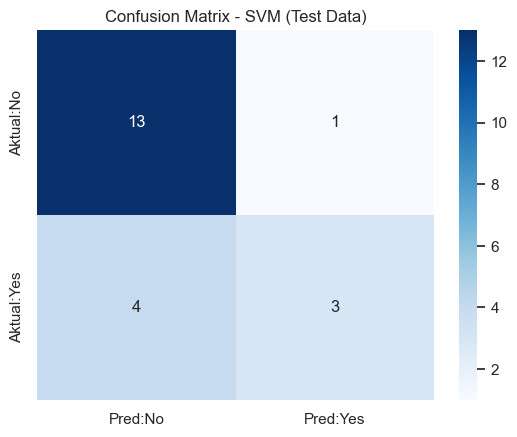

In [7]:

y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Akurasi Model: {acc:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Tidak Depresi','Depresi']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred:No','Pred:Yes'],
            yticklabels=['Aktual:No','Aktual:Yes'])
plt.title("Confusion Matrix - SVM (Test Data)")
plt.show()


In [10]:
from scipy import sparse

# Gunakan preprocessing yang sudah fit di dalam pipeline
preprocessor = svm_model.named_steps['prep']
encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']

# Transform seluruh X menggunakan encoder dari model
X_transformed = preprocessor.transform(X)

# Konversi dari sparse ke dense jika perlu
if sparse.issparse(X_transformed):
    X_transformed = X_transformed.toarray()

# Prediksi seluruh dataset
y_pred_all = svm_model.named_steps['model'].predict(X_transformed)

# Ambil nama kolom yang sesuai dengan model
num_names = [f'z_{c}' for c in num_cols]
oh_names = encoder.get_feature_names_out(cat_cols).tolist()
bin_names = bin_cols
all_cols = num_names + oh_names + bin_names

# Buat DataFrame hasil
processed_df = pd.DataFrame(X_transformed, columns=all_cols)
processed_df['Actual'] = y.values
processed_df['Predicted'] = y_pred_all

# Supaya tabel 5 teratas & terbawah tampil lengkap (tanpa terpotong)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# --- Output hasil ---
print("\n--- Lima Data Teratas (setelah pemrosesan & prediksi) ---")
print(processed_df.head())

print("\n--- Lima Data Terbawah (setelah pemrosesan & prediksi) ---")
print(processed_df.tail())

# Simpan hasil dataset bersih buat digunakan lagi
df_clean = df.copy()  # atau pakai nama DataFrame terakhir lo, misal processed_df
df_clean.to_csv("cleaned_student_mental_health.csv", index=False)
print("✅ Dataset bersih berhasil diekspor ke cleaned_student_mental_health.csv")




--- Lima Data Teratas (setelah pemrosesan & prediksi) ---
      z_Age    z_CGPA  Course_BCS  Course_BENL  Course_BIT  \
0 -1.037385 -0.144715         0.0          0.0         0.0   
1  0.195152 -0.144715         0.0          0.0         0.0   
2 -0.626540 -0.144715         0.0          0.0         1.0   
3  0.605997 -0.144715         0.0          0.0         0.0   
4  1.016843 -0.144715         0.0          0.0         0.0   

   Course_Banking Studies  Course_Benl  Course_Biomedical science  \
0                     0.0          0.0                        0.0   
1                     0.0          0.0                        0.0   
2                     0.0          0.0                        0.0   
3                     0.0          0.0                        0.0   
4                     0.0          0.0                        0.0   

   Course_Business Administration  Course_CTS  Course_Communication   \
0                             0.0         0.0                    0.0   
1        

c:\Users\Gilang-Aldiano\OneDrive\Dokumen\kuliah\Semester_5\Pembelajaran_Mesin\Tugas\Tugas_Minggu_ke-2\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
